In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_file = 'transactional-sample.csv'

# Attempt to load the file
try:
    ts = pd.read_csv(csv_file)
    print(f"File '{csv_file}' loaded successfully!")
    
    # Convert date column to datetime objects (Crucial for time analysis)
    ts['transaction_date'] = pd.to_datetime(ts['transaction_date'])

    print("\n--- First 5 transactions ---")
    display(ts.head())

    print("\n--- Last 5 transactions ---")
    display(ts.tail())
    
    print("\n--- Data Info ---")
    ts.info()
    
except FileNotFoundError:
    print(f"ERROR: The file '{csv_file}' was not found in the folder.")

File 'transactional-sample.csv' loaded successfully!

--- First 5 transactions ---


,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01 23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01 22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01 21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01 21:30:53.347051,55.36,860232.0,False



--- Last 5 transactions ---


,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
3194,21323592,50493,49581,650486******4139,2019-11-01 13:05:34.054967,744.15,NaN,False
3195,21323593,9603,59275,528052******3611,2019-11-01 11:47:02.404963,1403.67,NaN,False
3196,21323594,57997,84486,522688******9874,2019-11-01 10:23:50.555604,1.55,NaN,False
3197,21323595,35930,7,544315******7773,2019-11-01 01:29:45.799767,359.68,NaN,False
3198,21323596,17348,8,650487******9884,2019-11-01 01:27:15.811098,2416.70,NaN,False



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      3199 non-null   int64         
 1   merchant_id         3199 non-null   int64         
 2   user_id             3199 non-null   int64         
 3   card_number         3199 non-null   object        
 4   transaction_date    3199 non-null   datetime64[ns]
 5   transaction_amount  3199 non-null   float64       
 6   device_id           2369 non-null   float64       
 7   has_cbk             3199 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 178.2+ KB


--- DETAILED VALUE STATISTICS ---
Global Fraud Rate: 12.22%

Comparison Table ($):


,is_fraud,Mean,Median
0,False,672.32,360.32
1,True,1453.57,999.47


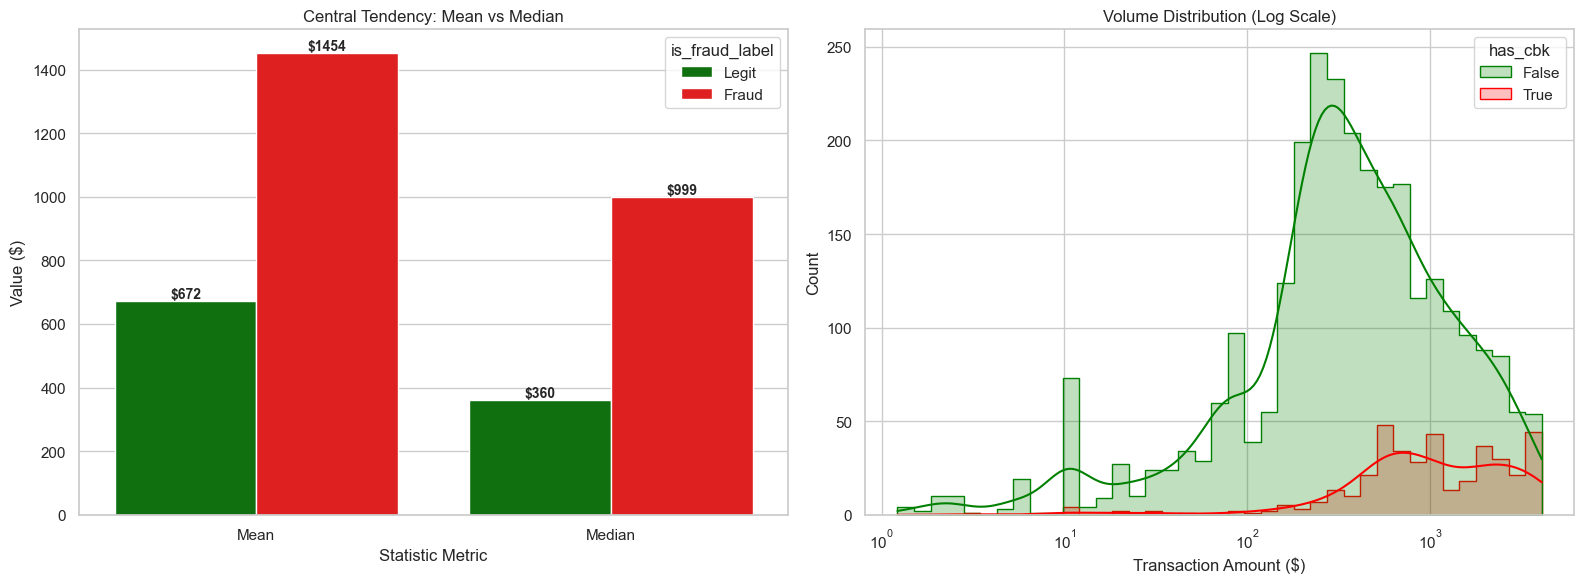


 KEY INSIGHTS (Mean vs Median):
----------------------------------------
1. MEDIAN (Typical Behavior):
   - Legit User: $360.31
   - Fraudster:  $999.47
   -> Conclusion: The 'typical' fraud is 2.8x larger than a normal purchase.

2. MEAN (Financial Impact):
   - Legit Avg:  $672.32
   - Fraud Avg:  $1453.57

   -> Data is fairly balanced (Mean and Median are close).


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


if not ts.empty:
    # 1. Segmentation
    frauds = ts[ts['has_cbk'] == True]
    legit = ts[ts['has_cbk'] == False]

    # 2. Calculating Statistics (Mean & Median)
    summary = ts.groupby('has_cbk')['transaction_amount'].agg(['mean', 'median']).reset_index()
    summary.columns = ['is_fraud', 'Mean', 'Median']
    
    # Melt for plotting
    summary_melted = summary.melt(id_vars='is_fraud', var_name='Metric', value_name='Value')
    summary_melted['is_fraud_label'] = summary_melted['is_fraud'].map({True: 'Fraud', False: 'Legit'})

    # --- TEXT REPORT ---
    print("--- DETAILED VALUE STATISTICS ---")
    print(f"Global Fraud Rate: {(len(frauds) / len(ts)) * 100:.2f}%") 
    print("\nComparison Table ($):")
    display(summary.round(2))

    # --- VISUALIZATIONS ---
    plt.figure(figsize=(16, 6))
    
    # CHART 1: Mean vs Median
    plt.subplot(1, 2, 1)
    sns.barplot(
        data=summary_melted, 
        x='Metric', 
        y='Value', 
        hue='is_fraud_label', 
        palette=['green', 'red']
    )
    plt.title("Central Tendency: Mean vs Median")
    plt.ylabel("Value ($)")
    plt.xlabel("Statistic Metric")
    
    # Add labels
    for p in plt.gca().patches:
        if p.get_height() > 0:
            plt.gca().annotate(f'${p.get_height():.0f}', 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha='center', va='bottom', fontsize=10, fontweight='bold')

    # CHART 2: Histogram (Log Scale)
    plt.subplot(1, 2, 2)
    sns.histplot(
        data=ts, 
        x='transaction_amount', 
        hue='has_cbk', 
        kde=True, 
        element="step", 
        palette=['green', 'red'], 
        log_scale=True
    )
    plt.title("Volume Distribution (Log Scale)")
    plt.xlabel("Transaction Amount ($)")
    
    plt.tight_layout()
    plt.show()

    # Extracting values
    f_median = summary.loc[summary['is_fraud'] == True, 'Median'].values[0]
    l_median = summary.loc[summary['is_fraud'] == False, 'Median'].values[0]
    
    f_mean = summary.loc[summary['is_fraud'] == True, 'Mean'].values[0]
    l_mean = summary.loc[summary['is_fraud'] == False, 'Mean'].values[0]
    
    print(f"\n KEY INSIGHTS (Mean vs Median):")
    print("-" * 40)
    print(f"1. MEDIAN (Typical Behavior):")
    print(f"   - Legit User: ${l_median:.2f}")
    print(f"   - Fraudster:  ${f_median:.2f}")
    print(f"   -> Conclusion: The 'typical' fraud is {(f_median/l_median):.1f}x larger than a normal purchase.")
    
    print(f"\n2. MEAN (Financial Impact):")
    print(f"   - Legit Avg:  ${l_mean:.2f}")
    print(f"   - Fraud Avg:  ${f_mean:.2f}")
    
    # Checking for outliers skewing the data
    if f_mean < f_median * 1.5:
        print("\n   -> Data is fairly balanced (Mean and Median are close).")

--- DEVICE ID ANALYSIS ---


,Device_Status,Total_Transactions,Total_Frauds,Fraud_Rate,Fraud_Rate_Percent
0,With Device ID,2369,324,0.14,13.68
1,Without Device ID,830,67,0.08,8.07


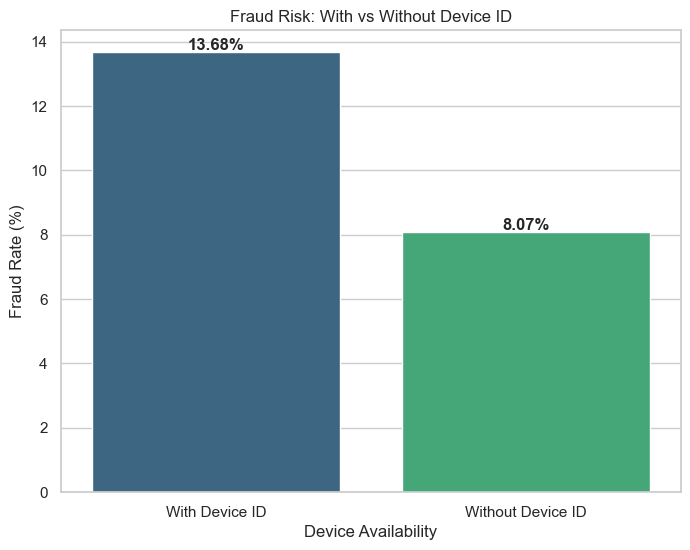


 KEY INSIGHT:
Transactions WITHOUT Device ID have a fraud rate of 8.07%.
Transactions WITH Device ID have a fraud rate of 13.68%.
CONCLUSION: Missing Device ID does not seem to impact risk significantly.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

if not ts.empty:
    # 1. Logic: Classification
    ts['has_device_id'] = ts['device_id'].notna()
    ts['device_status'] = ts['has_device_id'].map({True: 'With Device ID', False: 'Without Device ID'})

    # 2. Detailed Statistics (Count + Sum + Mean)
    # We aggregate to see Volume AND Risk
    device_stats = ts.groupby('device_status')['has_cbk'].agg(['count', 'sum', 'mean']).reset_index()
    device_stats.columns = ['Device_Status', 'Total_Transactions', 'Total_Frauds', 'Fraud_Rate']
    device_stats['Fraud_Rate_Percent'] = device_stats['Fraud_Rate'] * 100

    print("--- DEVICE ID ANALYSIS ---")
    display(device_stats.round(2))

    # --- VISUALIZATION ---
    plt.figure(figsize=(8, 6))
    plot = sns.barplot(
        data=device_stats, 
        x='Device_Status', 
        y='Fraud_Rate_Percent', 
        hue='Device_Status', 
        legend=False,
        palette='viridis'
    )
    plt.title("Fraud Risk: With vs Without Device ID")
    plt.ylabel("Fraud Rate (%)")
    plt.xlabel("Device Availability")
    
    # Add labels
    for p in plot.patches:
        if p.get_height() > 0:
            plot.annotate(f'{p.get_height():.2f}%', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontweight='bold')
    plt.show()

    # --- INSIGHTS ---
    # Check if we even have transactions without ID
    if 'Without Device ID' in device_stats['Device_Status'].values:
        rate_no_id = device_stats.loc[device_stats['Device_Status'] == 'Without Device ID', 'Fraud_Rate_Percent'].values[0]
        rate_with_id = device_stats.loc[device_stats['Device_Status'] == 'With Device ID', 'Fraud_Rate_Percent'].values[0]
        
        print(f"\n KEY INSIGHT:")
        print(f"Transactions WITHOUT Device ID have a fraud rate of {rate_no_id:.2f}%.")
        print(f"Transactions WITH Device ID have a fraud rate of {rate_with_id:.2f}%.")
        
        if rate_no_id > rate_with_id * 1.5:
            print("CONCLUSION: Missing Device ID is a High-Risk indicator.")
        else:
            print("CONCLUSION: Missing Device ID does not seem to impact risk significantly.")

BIN ANALYSIS (LAPLACE SMOOTHING)...

--- Top 5 Riskiest Banks (Laplace Score) ---


,BIN,Total_Trans,Frauds,Laplace_Score,Laplace_Score_Percent,Raw_Rate_Percent
376,554482,10,10,0.916667,91.666667,100.000000
267,530034,35,24,0.675676,67.567568,68.571429
113,459080,6,4,0.625000,62.500000,66.666667
19,406655,73,43,0.586667,58.666667,58.904110
56,421960,6,3,0.500000,50.000000,50.000000


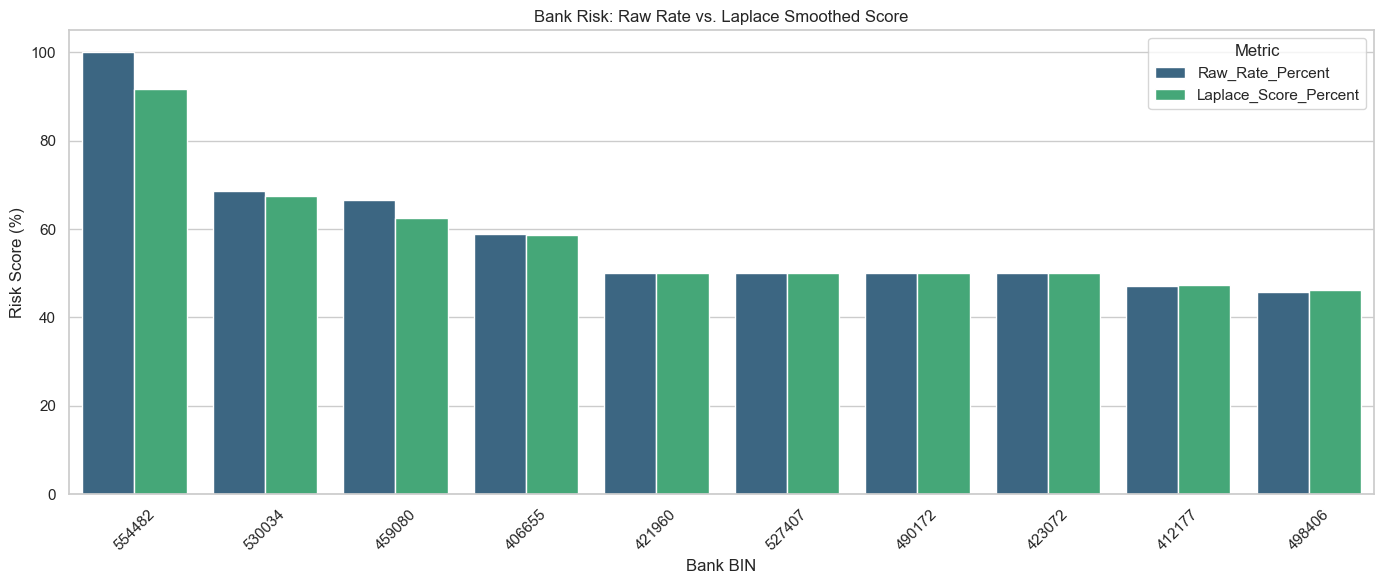

  -> If Laplace Score is high (> 50%), the bank is genuinely risky.


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


if not ts.empty and 'card_number' in ts.columns:
    print("BIN ANALYSIS (LAPLACE SMOOTHING)...")
    
    # 1. Extract BIN (First 6 digits)
    ts['card_bin'] = ts['card_number'].astype(str).str[:6]
    
    # 2. Basic Stats
    bin_stats = ts.groupby('card_bin')['has_cbk'].agg(['count', 'sum']).reset_index()
    bin_stats.columns = ['BIN', 'Total_Trans', 'Frauds']
    
    # --- 3. THE LAPLACE FORMULA  ---
    # This pulls small banks towards 50% and prevents extreme 0% or 100% rates.
    bin_stats['Laplace_Score'] = (bin_stats['Frauds'] + 1) / (bin_stats['Total_Trans'] + 2)
    
    bin_stats['Laplace_Score_Percent'] = bin_stats['Laplace_Score'] * 100
    bin_stats['Raw_Rate_Percent'] = (bin_stats['Frauds'] / bin_stats['Total_Trans']) * 100

    # 4. Filter & Sort
    # We want to see the Highest Risk Scores
    # We filter out bins with extremely low volume (e.g. < 5) just to keep the chart clean
    relevant_bins = bin_stats[bin_stats['Total_Trans'] > 5].sort_values(by='Laplace_Score', ascending=False)

    print(f"\n--- Top 5 Riskiest Banks (Laplace Score) ---")
    display(relevant_bins.head(5))

    # Comparing Raw Rate vs Laplace Score
    top_risky = relevant_bins.head(10)
    
    # Melt for comparison plotting
    bin_melted = top_risky.melt(id_vars='BIN', 
                                value_vars=['Raw_Rate_Percent', 'Laplace_Score_Percent'], 
                                var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(14, 6))
    
    # Green = The Adjusted Score (Use this for rules)
    # Purple = The Raw Rate (Can be misleading)
    sns.barplot(data=bin_melted, x='BIN', y='Score', hue='Metric', palette='viridis')
    
    plt.title("Bank Risk: Raw Rate vs. Laplace Smoothed Score")
    plt.ylabel("Risk Score (%)")
    plt.xlabel("Bank BIN")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    
    plt.tight_layout()
    plt.show()

    print("  -> If Laplace Score is high (> 50%), the bank is genuinely risky.")

ANALYZING CARD SHARING (LINK ANALYSIS)...

--- Card Sharing Statistics ---


,Status,Total_Trans,Fraud_Rate,Fraud_Rate_Percent
1,Shared (2-3 Users),67,0.343284,34.328358
0,Carding Ring (>3 Users),4,0.250000,25.000000
2,Single User (Normal),3128,0.117327,11.732737


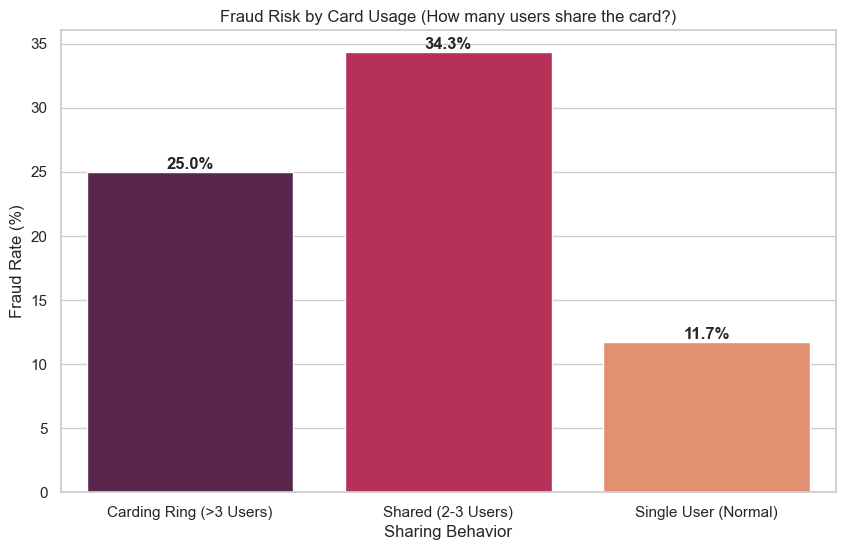


 Sharing behavior observed, but rates are within control.


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if not ts.empty and 'card_number' in ts.columns:
    print("ANALYZING CARD SHARING (LINK ANALYSIS)...")
    
    # 1. Calculate how many unique Users are using each Card
    # Group by Card -> Count Unique User IDs
    card_usage = ts.groupby('card_number')['user_id'].nunique().reset_index()
    card_usage.columns = ['card_number', 'unique_users_count']
    
    # 2. Map this back to the main dataframe
    # Now every transaction knows: "This card is used by X people"
    ts['users_per_card'] = ts['card_number'].map(ts.groupby('card_number')['user_id'].nunique())
    
    # 3. Define "Shared Card" status
    # If > 1 person uses it, it's shared. If > 3, it's highly suspicious.
    ts['card_sharing_status'] = ts['users_per_card'].apply(
        lambda x: 'Single User (Normal)' if x == 1 else ('Shared (2-3 Users)' if x <= 3 else 'Carding Ring (>3 Users)')
    )

    # 4. Calculate Fraud Rate for each group
    sharing_stats = ts.groupby('card_sharing_status')['has_cbk'].agg(['count', 'mean']).reset_index()
    sharing_stats.columns = ['Status', 'Total_Trans', 'Fraud_Rate']
    sharing_stats['Fraud_Rate_Percent'] = sharing_stats['Fraud_Rate'] * 100

    print("\n--- Card Sharing Statistics ---")
    display(sharing_stats.sort_values(by='Fraud_Rate', ascending=False))

    # --- VISUALIZATION ---
    plt.figure(figsize=(10, 6))
    
    plot = sns.barplot(
        data=sharing_stats, 
        x='Status', 
        y='Fraud_Rate_Percent', 
        hue='Status',
        legend=False,
        palette='rocket'
    )
    
    plt.title("Fraud Risk by Card Usage (How many users share the card?)")
    plt.ylabel("Fraud Rate (%)")
    plt.xlabel("Sharing Behavior")
    
    # Add labels
    for p in plot.patches:
        if p.get_height() > 0:
            plot.annotate(f'{p.get_height():.1f}%', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom', fontweight='bold')
    
    plt.show()
    
    # --- INSIGHT ---
    ring_rate = sharing_stats.loc[sharing_stats['Status'] == 'Carding Ring (>3 Users)', 'Fraud_Rate_Percent']
    
    if not ring_rate.empty and ring_rate.values[0] > 50:
        print(f"\n CRITICAL ALERT: Cards used by multiple accounts are {ring_rate.values[0]:.1f}% likely to be fraud!")
        print("   -> Recommendation: Immediate BLOCK on any card associated with > 3 different User IDs.")
    else:
        print("\n Sharing behavior observed, but rates are within control.")

else:
    print(" 'card_number' column not found.")

ANALYZING CARD HOPPING (CARDS PER USER)...

--- Card Hopping Statistics ---


,Status,Total_Trans,Fraud_Rate,Fraud_Rate_Percent
0,1 Card (Normal),2764,0.057525,5.752533
1,2 Cards (Low Risk),181,0.348066,34.806630
2,3 Cards (Medium Risk),57,0.596491,59.649123
3,4+ Cards (High Risk),197,0.685279,68.527919


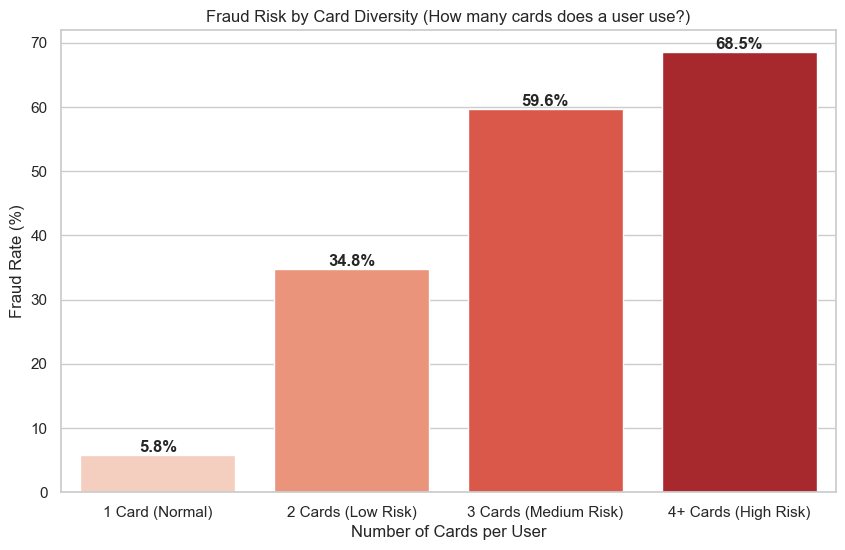


 STRONG SIGNAL FOUND: Users with 4+ cards have a 68.5% fraud rate.
   -> RECOMMENDATION: Flag any user attempting to add a 4th card.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


if not ts.empty:
    print("ANALYZING CARD HOPPING (CARDS PER USER)...")
    
    # 1. Calculate how many unique Cards each User has used
    # Group by User -> Count Unique Card Numbers
    user_card_counts = ts.groupby('user_id')['card_number'].nunique().reset_index()
    user_card_counts.columns = ['user_id', 'unique_cards_count']
    

    mapper = user_card_counts.set_index('user_id')['unique_cards_count']
    ts['cards_per_user'] = ts['user_id'].map(mapper)
    # ---------------------
    
    # 3. Create Buckets for easier analysis
    def classify_hopping(n):
        if n == 1: return '1 Card (Normal)'
        elif n == 2: return '2 Cards (Low Risk)'
        elif n == 3: return '3 Cards (Medium Risk)'
        else: return '4+ Cards (High Risk)'
        
    ts['hopping_status'] = ts['cards_per_user'].apply(classify_hopping)

    # 4. Calculate Fraud Rate for each group
    hopping_stats = ts.groupby('hopping_status')['has_cbk'].agg(['count', 'mean']).reset_index()
    hopping_stats.columns = ['Status', 'Total_Trans', 'Fraud_Rate']
    hopping_stats['Fraud_Rate_Percent'] = hopping_stats['Fraud_Rate'] * 100
    
    # Sort logic
    sort_order = ['1 Card (Normal)', '2 Cards (Low Risk)', '3 Cards (Medium Risk)', '4+ Cards (High Risk)']
    hopping_stats['Status'] = pd.Categorical(hopping_stats['Status'], categories=sort_order, ordered=True)
    hopping_stats = hopping_stats.sort_values('Status')

    print("\n--- Card Hopping Statistics ---")
    display(hopping_stats)

    # --- VISUALIZATION ---
    plt.figure(figsize=(10, 6))
    
    plot = sns.barplot(
        data=hopping_stats, 
        x='Status', 
        y='Fraud_Rate_Percent', 
        hue='Status',
        legend=False,
        palette='Reds'
    )
    
    plt.title("Fraud Risk by Card Diversity (How many cards does a user use?)")
    plt.ylabel("Fraud Rate (%)")
    plt.xlabel("Number of Cards per User")
    
    for p in plot.patches:
        if p.get_height() > 0:
            plot.annotate(f'{p.get_height():.1f}%', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom', fontweight='bold')
    
    plt.show()
    
    # --- INSIGHT ---
    high_risk_group = hopping_stats.loc[hopping_stats['Status'] == '4+ Cards (High Risk)']
    
    if not high_risk_group.empty and high_risk_group['Fraud_Rate_Percent'].values[0] > 30:
        print(f"\n STRONG SIGNAL FOUND: Users with 4+ cards have a {high_risk_group['Fraud_Rate_Percent'].values[0]:.1f}% fraud rate.")
        print("   -> RECOMMENDATION: Flag any user attempting to add a 4th card.")
    else:
        print("\n No extreme card hopping behavior detected.")

 ANALYZING DEVICE SHARING (DEVICE FARMS)...

--- Device Sharing Statistics ---


,Status,Total_Trans,Fraud_Rate,Fraud_Rate_Percent
1,No Device ID,830,0.080723,8.072289
0,1 User (Personal),2369,0.136767,13.676657


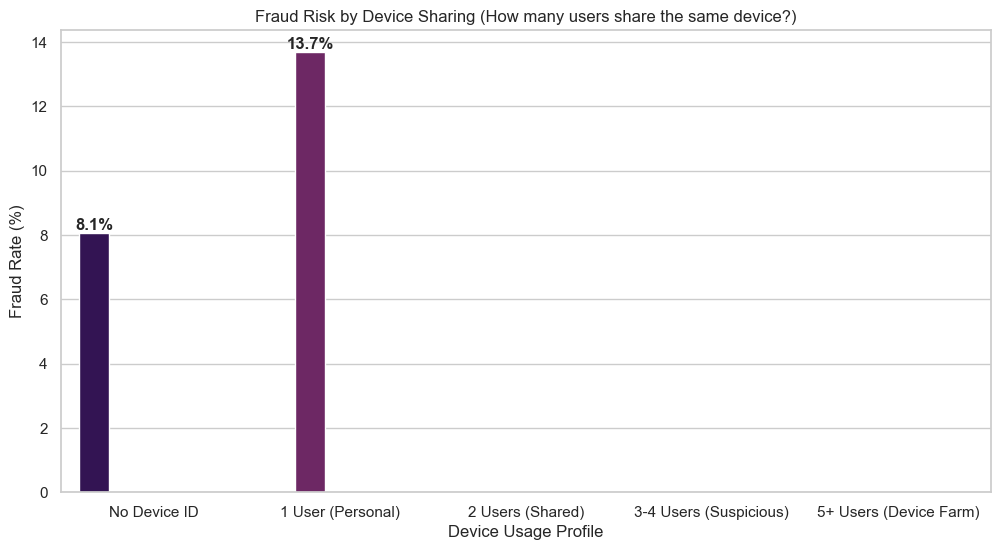


 No massive device farms detected (sharing is within normal limits).


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Style configuration
sns.set_theme(style="whitegrid")

if not ts.empty:
    print(" ANALYZING DEVICE SHARING (DEVICE FARMS)...")
    
    # 1. Filter only transactions that HAVE a device_id
    devices_only = ts[ts['device_id'].notna()].copy()
    
    # 2. Calculate how many unique Users accessed each Device
    # Group by Device -> Count Unique User IDs
    device_user_counts = devices_only.groupby('device_id')['user_id'].nunique()
    
    # 3. Map this count back to the main dataframe
    # Note: Transactions with no device_id will get NaN here, which is fine
    ts['users_per_device'] = ts['device_id'].map(device_user_counts)
    
    # 4. Create Risk Buckets
    def classify_sharing(n):
        if pd.isna(n): return 'No Device ID'
        if n == 1: return '1 User (Personal)'
        elif n == 2: return '2 Users (Shared)'
        elif n <= 4: return '3-4 Users (Suspicious)'
        else: return '5+ Users (Device Farm)'
        
    ts['device_sharing_status'] = ts['users_per_device'].apply(classify_sharing)

    # 5. Calculate Fraud Rate
    sharing_stats = ts.groupby('device_sharing_status')['has_cbk'].agg(['count', 'mean']).reset_index()
    sharing_stats.columns = ['Status', 'Total_Trans', 'Fraud_Rate']
    sharing_stats['Fraud_Rate_Percent'] = sharing_stats['Fraud_Rate'] * 100
    
    # Sort for display
    sort_order = ['No Device ID', '1 User (Personal)', '2 Users (Shared)', '3-4 Users (Suspicious)', '5+ Users (Device Farm)']
    sharing_stats['Status'] = pd.Categorical(sharing_stats['Status'], categories=sort_order, ordered=True)
    sharing_stats = sharing_stats.sort_values('Status')

    print("\n--- Device Sharing Statistics ---")
    display(sharing_stats)

    # --- VISUALIZATION ---
    plt.figure(figsize=(12, 6))
    
    plot = sns.barplot(
        data=sharing_stats, 
        x='Status', 
        y='Fraud_Rate_Percent', 
        hue='Status',
        legend=False,
        palette='inferno'
    )
    
    plt.title("Fraud Risk by Device Sharing (How many users share the same device?)")
    plt.ylabel("Fraud Rate (%)")
    plt.xlabel("Device Usage Profile")
    
    for p in plot.patches:
        if p.get_height() > 0:
            plot.annotate(f'{p.get_height():.1f}%', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom', fontweight='bold')
    
    plt.show()
    
    # --- INSIGHT ---
    farm_group = sharing_stats.loc[sharing_stats['Status'] == '5+ Users (Device Farm)']
    
    if not farm_group.empty and farm_group['Fraud_Rate_Percent'].values[0] > 40:
        print(f"\n CRITICAL RED FLAG: Devices with 5+ users have a {farm_group['Fraud_Rate_Percent'].values[0]:.1f}% fraud rate.")
        print("   -> This confirms the presence of DEVICE FARMS (Emulators/Bots).")
        print("   -> ACTION: Automatically block any device used by more than 4 unique accounts.")
    else:
        print("\n No massive device farms detected (sharing is within normal limits).")

CALCULATING RISK PARAMETERS (USER & MERCHANT SCORES)...

TOP 10 RISKIEST USERS (Block Candidates)


,user_id,Total_Trans,Total_Frauds,Risk_Score,Risk_Score_Percent,Raw_Rate_Percent
2020,75710,10,10,0.916667,91.666667,100.000000
211,7725,7,7,0.888889,88.888889,100.000000
2582,96025,14,13,0.875000,87.500000,92.857143
484,17929,6,6,0.875000,87.500000,100.000000
584,21768,6,6,0.875000,87.500000,100.000000
2085,78262,13,12,0.866667,86.666667,92.307692
2683,99396,5,5,0.857143,85.714286,100.000000
1904,71424,5,5,0.857143,85.714286,100.000000
2316,86411,5,5,0.857143,85.714286,100.000000
741,28218,5,5,0.857143,85.714286,100.000000



 TOP 10 SAFEST USERS


,user_id,Total_Trans,Total_Frauds,Risk_Score,Risk_Score_Percent,Raw_Rate_Percent
1279,49106,7,0,0.111111,11.111111,0.0
2080,77959,7,0,0.111111,11.111111,0.0
1056,40779,6,0,0.125000,12.500000,0.0
907,34548,6,0,0.125000,12.500000,0.0
1768,67245,5,0,0.142857,14.285714,0.0
2050,76837,4,0,0.166667,16.666667,0.0
2361,88553,4,0,0.166667,16.666667,0.0
341,13001,4,0,0.166667,16.666667,0.0
493,18205,4,0,0.166667,16.666667,0.0
1988,74585,4,0,0.166667,16.666667,0.0



TOP 10 RISKIEST MERCHANTS (Audit Targets)


,merchant_id,Total_Trans,Total_Frauds,Risk_Score,Risk_Score_Percent,Raw_Rate_Percent
20,1308,15,15,0.941176,94.117647,100.0
830,44927,11,11,0.923077,92.307692,100.0
1309,73271,10,10,0.916667,91.666667,100.0
704,38337,6,6,0.875000,87.500000,100.0
1445,81795,6,6,0.875000,87.500000,100.0
879,48126,6,6,0.875000,87.500000,100.0
1341,75917,6,6,0.875000,87.500000,100.0
710,38568,5,5,0.857143,85.714286,100.0
168,8942,5,5,0.857143,85.714286,100.0
302,15326,5,5,0.857143,85.714286,100.0



TOP 10 SAFEST MERCHANTS (Trusted Partners)


,merchant_id,Total_Trans,Total_Frauds,Risk_Score,Risk_Score_Percent,Raw_Rate_Percent
896,49205,73,0,0.013333,1.333333,0.0
1405,79698,22,0,0.041667,4.166667,0.0
508,26765,18,0,0.050000,5.000000,0.0
341,17348,16,0,0.055556,5.555556,0.0
510,26981,16,0,0.055556,5.555556,0.0
777,42178,15,0,0.058824,5.882353,0.0
66,4129,14,0,0.062500,6.250000,0.0
679,36929,13,0,0.066667,6.666667,0.0
561,29931,12,0,0.071429,7.142857,0.0
1648,93881,11,0,0.076923,7.692308,0.0


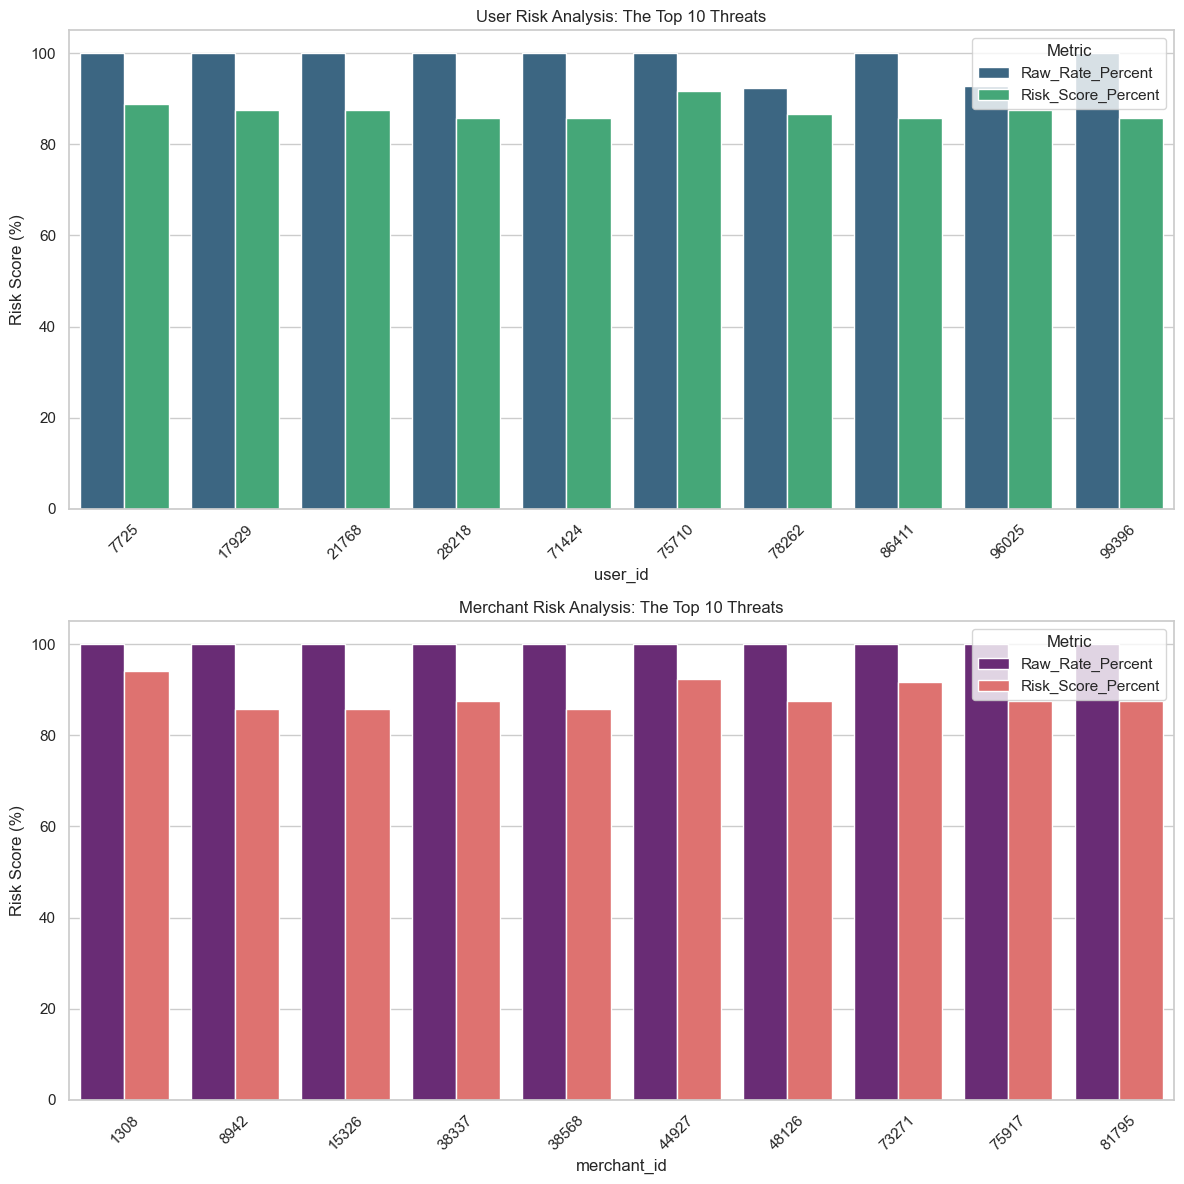


INSIGHTS:
1. The 'Safest' entities have huge volume and 0 frauds.
   -> Their Laplace Score is near 0% (e.g., 0.1%).
   -> Strategy: Add these IDs to a 'Fast Track' list to skip extensive checks.
2. The 'Riskiest' have high fraud counts relative to their volume.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- MAIN ANALYSIS ---
if not ts.empty:
    print("CALCULATING RISK PARAMETERS (USER & MERCHANT SCORES)...")

    # Function to calculate Laplace Score
    def get_risk_scores(df, entity_col):
        stats = df.groupby(entity_col)['has_cbk'].agg(['count', 'sum']).reset_index()
        stats.columns = [entity_col, 'Total_Trans', 'Total_Frauds']
        
        # Laplace Formula: (Frauds + 1) / (Total + 2) chosen because it shines when facing small samples
        # Low Score = Safe (High Volume, Low Fraud)
        # High Score = Risky (Low Volume OR High Fraud)
        stats['Risk_Score'] = (stats['Total_Frauds'] + 1) / (stats['Total_Trans'] + 2)
        stats['Risk_Score_Percent'] = stats['Risk_Score'] * 100
        
        stats['Raw_Rate_Percent'] = (stats['Total_Frauds'] / stats['Total_Trans']) * 100
        
        # Sort Descending (Highest Risk First)
        return stats.sort_values(by='Risk_Score', ascending=False)

    # --- A. USER RISK SCORES ---
    user_scores = get_risk_scores(ts, 'user_id')
    
    # 1. THE RISKIEST (Top of the list)
    risky_users = user_scores.head(10)
    
    # 2. THE SAFEST (Bottom of the list)
    safest_users = user_scores.tail(10).sort_values('Risk_Score', ascending=True)

    print("\n" + "="*50)
    print("TOP 10 RISKIEST USERS (Block Candidates)")
    print("="*50)
    display(risky_users)
    
    print("\n" + "="*50)
    print(" TOP 10 SAFEST USERS")
    print("="*50)
    display(safest_users)

    # --- B. MERCHANT RISK SCORES ---
    merchant_scores = get_risk_scores(ts, 'merchant_id')
    
    risky_merchants = merchant_scores.head(10)
    safest_merchants = merchant_scores.tail(10).sort_values('Risk_Score', ascending=True)

    print("\n" + "="*50)
    print("TOP 10 RISKIEST MERCHANTS (Audit Targets)")
    print("="*50)
    display(risky_merchants)
    
    print("\n" + "="*50)
    print("TOP 10 SAFEST MERCHANTS (Trusted Partners)")
    print("="*50)
    display(safest_merchants)

    # --- C. VISUALIZATION (Comparison) ---
    fig, ax = plt.subplots(2, 1, figsize=(12, 12))

    # Chart 1: Risky Users
    user_melt = risky_users.melt(id_vars='user_id', 
                                 value_vars=['Raw_Rate_Percent', 'Risk_Score_Percent'], 
                                 var_name='Metric', value_name='Score')
    
    sns.barplot(data=user_melt, x='user_id', y='Score', hue='Metric', palette='viridis', ax=ax[0])
    ax[0].set_title("User Risk Analysis: The Top 10 Threats")
    ax[0].set_ylabel("Risk Score (%)")
    ax[0].tick_params(axis='x', rotation=45)

    # Chart 2: Risky Merchants
    merchant_melt = risky_merchants.melt(id_vars='merchant_id', 
                                         value_vars=['Raw_Rate_Percent', 'Risk_Score_Percent'], 
                                         var_name='Metric', value_name='Score')
    
    sns.barplot(data=merchant_melt, x='merchant_id', y='Score', hue='Metric', palette='magma', ax=ax[1])
    ax[1].set_title("Merchant Risk Analysis: The Top 10 Threats")
    ax[1].set_ylabel("Risk Score (%)")
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()
    
    print("\nINSIGHTS:")
    print("1. The 'Safest' entities have huge volume and 0 frauds.")
    print("   -> Their Laplace Score is near 0% (e.g., 0.1%).")
    print("   -> Strategy: Add these IDs to a 'Fast Track' list to skip extensive checks.")
    print("2. The 'Riskiest' have high fraud counts relative to their volume.")

else:
    print("DataFrame 'ts' is empty.")

 File loaded successfully!

--- Detailed Velocity Risk ---


,Time_Interval,Total_Trans,Fraud_Rate,Fraud_Rate_Percent
0,00-05 min,65,0.492308,49.230769
4,05-30 min,111,0.657658,65.765766
9,30-60 min,49,0.755102,75.510204
1,01-02 hours,41,0.707317,70.731707
2,02-04 hours,26,0.461538,46.153846
3,04-08 hours,14,0.357143,35.714286
5,08-12 hours,7,0.428571,42.857143
6,12-16 hours,11,0.545455,54.545455
7,16-24 hours,39,0.615385,61.538462
8,24+ hours,2836,0.059944,5.994358


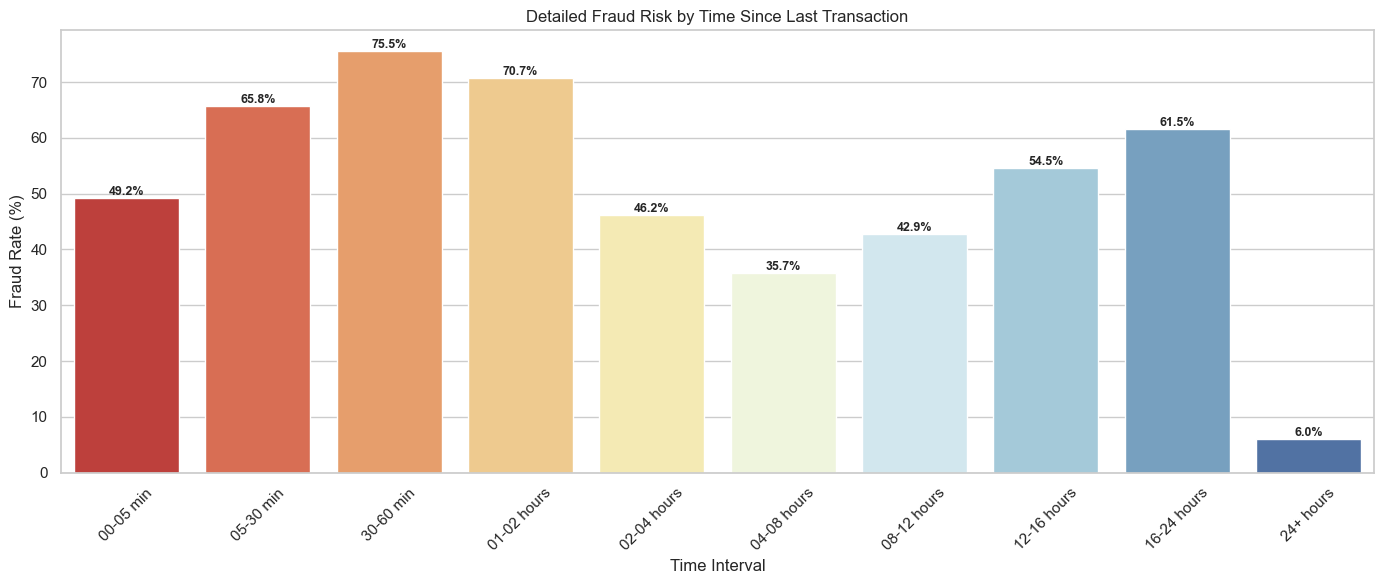


 INSIGHT:
• Fastest Transactions (0-5m): 49.2% Fraud Rate
• Slowest Transactions (24h+): 6.0% Fraud Rate
-> PATTERN: Fraudsters act significantly faster than normal users, but there is a resurgence after some hours pass


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


if 'ts' not in locals():
    try:
        ts = pd.read_csv('transactional-sample.csv')
        ts['transaction_date'] = pd.to_datetime(ts['transaction_date'])
    except FileNotFoundError:
        print(" Error: File not found.")
        ts = pd.DataFrame()

# --- MAIN ANALYSIS ---
if not ts.empty:
    
    # 1. Sort data by User and Date (Crucial)
    ts = ts.sort_values(by=['user_id', 'transaction_date'])
    
    # 2. Calculate Seconds since last transaction
    ts['time_since_last'] = ts.groupby('user_id')['transaction_date'].diff().dt.total_seconds()
    ts['time_since_last'] = ts['time_since_last'].fillna(9999999)

    # 3. Create Granular Time Buckets
    def classify_velocity(seconds):
        if seconds <= 300: return '00-05 min'          # <= 5m
        elif seconds <= 1800: return '05-30 min'       # <= 30m
        elif seconds <= 3600: return '30-60 min'       # <= 1h
        elif seconds <= 7200: return '01-02 hours'     # <= 2h
        elif seconds <= 14400: return '02-04 hours'    # <= 4h
        elif seconds <= 28800: return '04-08 hours'    # <= 8h
        elif seconds <= 43200: return '08-12 hours'    # <= 12h
        elif seconds <= 57600: return '12-16 hours'    # <= 16h
        elif seconds <= 86400: return '16-24 hours'    # <= 24h
        else: return '24+ hours'                       # > 1 day

    ts['velocity_bucket'] = ts['time_since_last'].apply(classify_velocity)
    
    # Define specific order for chart
    bucket_order = [
        '00-05 min', '05-30 min', '30-60 min', 
        '01-02 hours', '02-04 hours', '04-08 hours', 
        '08-12 hours', '12-16 hours', '16-24 hours', 
        '24+ hours'
    ]

    # 4. Statistics
    velocity_stats = ts.groupby('velocity_bucket')['has_cbk'].agg(['count', 'mean']).reset_index()
    velocity_stats.columns = ['Time_Interval', 'Total_Trans', 'Fraud_Rate']
    velocity_stats['Fraud_Rate_Percent'] = velocity_stats['Fraud_Rate'] * 100
    
    # Apply sort order
    velocity_stats['Time_Interval'] = pd.Categorical(velocity_stats['Time_Interval'], categories=bucket_order, ordered=True)
    velocity_stats = velocity_stats.sort_values('Time_Interval')

    print("\n--- Detailed Velocity Risk ---")
    display(velocity_stats)

    # --- VISUALIZATION ---
    plt.figure(figsize=(14, 6))
    
    plot = sns.barplot(
        data=velocity_stats, 
        x='Time_Interval', 
        y='Fraud_Rate_Percent', 
        hue='Time_Interval',
        legend=False,
        palette='RdYlBu' # Red (Short/Fast) -> Blue (Long/Slow)
    )
    
    plt.title("Detailed Fraud Risk by Time Since Last Transaction")
    plt.ylabel("Fraud Rate (%)")
    plt.xlabel("Time Interval")
    plt.xticks(rotation=45)
    
    # Add labels
    for p in plot.patches:
        if p.get_height() > 0:
            plot.annotate(f'{p.get_height():.1f}%', 
                          (p.get_x() + p.get_width() / 2., p.get_height()), 
                          ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # --- INSIGHT ---
    fastest = velocity_stats.iloc[0]['Fraud_Rate_Percent']
    slowest = velocity_stats.iloc[-1]['Fraud_Rate_Percent']
    
    print(f"\n INSIGHT:")
    print(f"• Fastest Transactions (0-5m): {fastest:.1f}% Fraud Rate")
    print(f"• Slowest Transactions (24h+): {slowest:.1f}% Fraud Rate")
    
    if fastest > slowest * 2:
        print("-> PATTERN: Fraudsters act significantly faster than normal users, but there is a resurgence after some hours pass")
else:
    print(" DataFrame 'ts' is empty.")